<a href="https://colab.research.google.com/github/Riddhi73/Evaluation_Assignment/blob/main/Eva_Pipe.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Necessary Library**

In [ ]:
%pip install transformers scikit-learn torch autocorrect tensorboard efficientnet_pytorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 622.8/622.8 kB 7.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for autocorrect: filename=autocorrect-2.6.1-py3-none-any.whl size=622364 sha256=bfa007bde34217815b5be49f029323307678129e3942c1b1c306660e3ee7b2e7
  Stored in directory: /root/.cache/pip/wheels/b6/28/c2/9ddf8f57f871b55b6fd0ab99c887531fb9a66e5ff236b82aee
  Created wheel for efficientnet_pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16426 sha256=8ea091f6082a73b39cfa2e3bf32e79fdf54b6f3f213f8277b04149f81bb325e9
  Stored in directory: /root/.cache/pip/wheels/9c/3f/43/e6271c7026fe08c185da2be23c98c8e87477d3db63f41f32ad
Successfully built autocorrect efficientnet_pytorch


In [ ]:
import pandas as pd
from transformers import AutoTokenizer,RobertaModel, RobertaTokenizer, DistilBertModel, DistilBertTokenizer, RobertaForSequenceClassification, ViTFeatureExtractor, ViTModel
import torch
import tqdm
from torchvision.models import resnet50, ResNet50_Weights
import torch.nn as nn
import os
import cv2
import math
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
import nltk
from nltk.corpus import stopwords
import re
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import json
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
from sklearn.utils.class_weight import compute_class_weight
from PIL import Image
import requests
from torchvision import transforms
from tqdm.auto import tqdm
from efficientnet_pytorch import EfficientNet
import torch.optim as optim

# **EDA**

In [ ]:
# Load the multimodal training data
try:
    # Try reading with comma delimiter (default)
    multimodal_train_df = pd.read_csv('/content/drive/MyDrive/Eva_Pipe/multimodal_train.csv')
except pd.errors.ParserError as e:
    print(f"ParserError with comma delimiter: {e}")
    try:
        # Try reading with tab delimiter
        multimodal_train_df = pd.read_csv('/content/drive/MyDrive/Eva_Pipe/multimodal_train.csv', sep='\t')
        print("Successfully loaded with tab delimiter.")
    except pd.errors.ParserError as e:
        print(f"ParserError with tab delimiter: {e}")
        try:
            # Try reading with semicolon delimiter
            multimodal_train_df = pd.read_csv('/content/drive/MyDrive/Eva_Pipe/multimodal_train.csv', sep=';')
            print("Successfully loaded with semicolon delimiter.")
        except pd.errors.ParserError as e:
            print(f"ParserError with semicolon delimiter: {e}")
            print("Could not load the CSV with common delimiters. Please check the file content and delimiter.")
            multimodal_train_df = None # Set to None if loading fails

# Display the first few rows if the dataframe was loaded
if multimodal_train_df is not None:
    print("First 5 rows of the multimodal training data:")
    display(multimodal_train_df.head())

    # Display information about the dataframe (columns, data types, non-null values)
    print("\nInformation about the multimodal training data:")
    display(multimodal_train_df.info())

    # Display basic descriptive statistics for numerical columns
    print("\nDescriptive statistics for numerical columns:")
    display(multimodal_train_df.describe())

ParserError with comma delimiter: Error tokenizing data. C error: Expected 1 fields in line 12, saw 4

Successfully loaded with tab delimiter.
First 5 rows of the multimodal training data:


,author,clean_title,created_utc,domain,hasImage,id,image_url,linked_submission_id,num_comments,score,subreddit,title,upvote_ratio,2_way_label,3_way_label,6_way_label
0,Alexithymia,my walgreens offbrand mucinex was engraved wit...,1.551641e+09,i.imgur.com,True,awxhir,https://external-preview.redd.it/WylDbZrnbvZdB...,NaN,2.0,12,mildlyinteresting,My Walgreens offbrand Mucinex was engraved wit...,0.84,1,0,0
1,VIDCAs17,this concerned sink with a tiny hat,1.534727e+09,i.redd.it,True,98pbid,https://preview.redd.it/wsfx0gp0f5h11.jpg?widt...,NaN,2.0,119,pareidolia,This concerned sink with a tiny hat,0.99,0,2,2
2,prometheus1123,hackers leak emails from uae ambassador to us,1.496511e+09,aljazeera.com,True,6f2cy5,https://external-preview.redd.it/6fNhdbc6K1vFA...,NaN,1.0,44,neutralnews,Hackers leak emails from UAE ambassador to US,0.92,1,0,0
3,NaN,puppy taking in the view,1.471341e+09,i.imgur.com,True,4xypkv,https://external-preview.redd.it/HLtVNhTR6wtYt...,NaN,26.0,250,photoshopbattles,PsBattle: Puppy taking in the view,0.95,1,0,0
4,3rikR3ith,i found a face in my sheet music too,1.525318e+09,i.redd.it,True,8gnet9,https://preview.redd.it/ri7ut2wn8kv01.jpg?widt...,NaN,2.0,13,pareidolia,I found a face in my sheet music too!,0.84,0,2,2



Information about the multimodal training data:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 564000 entries, 0 to 563999
Data columns (total 16 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   author                535290 non-null  object 
 1   clean_title           564000 non-null  object 
 2   created_utc           564000 non-null  float64
 3   domain                396143 non-null  object 
 4   hasImage              564000 non-null  bool   
 5   id                    564000 non-null  object 
 6   image_url             562466 non-null  object 
 7   linked_submission_id  167857 non-null  object 
 8   num_comments          396143 non-null  float64
 9   score                 564000 non-null  int64  
 10  subreddit             564000 non-null  object 
 11  title                 564000 non-null  object 
 12  upvote_ratio          396143 non-null  float64
 13  2_way_label           564000 non-null  int64  
 14  3_w

None


Descriptive statistics for numerical columns:


,created_utc,num_comments,score,upvote_ratio,2_way_label,3_way_label,6_way_label
count,5.640000e+05,396143.000000,564000.000000,396143.000000,564000.000000,564000.000000,564000.000000
mean,1.478727e+09,20.363525,395.449160,0.855361,0.393761,1.187926,1.884012
std,6.970407e+07,141.460211,3049.910636,0.110111,0.488583,0.969604,1.782309
min,1.212297e+09,0.000000,-950.000000,0.500000,0.000000,0.000000,0.000000
25%,1.418176e+09,1.000000,5.000000,0.780000,0.000000,0.000000,0.000000
50%,1.488981e+09,2.000000,14.000000,0.880000,0.000000,2.000000,2.000000
75%,1.550486e+09,7.000000,46.000000,0.940000,1.000000,2.000000,4.000000
max,1.573859e+09,10783.000000,137179.000000,1.000000,1.000000,2.000000,5.000000


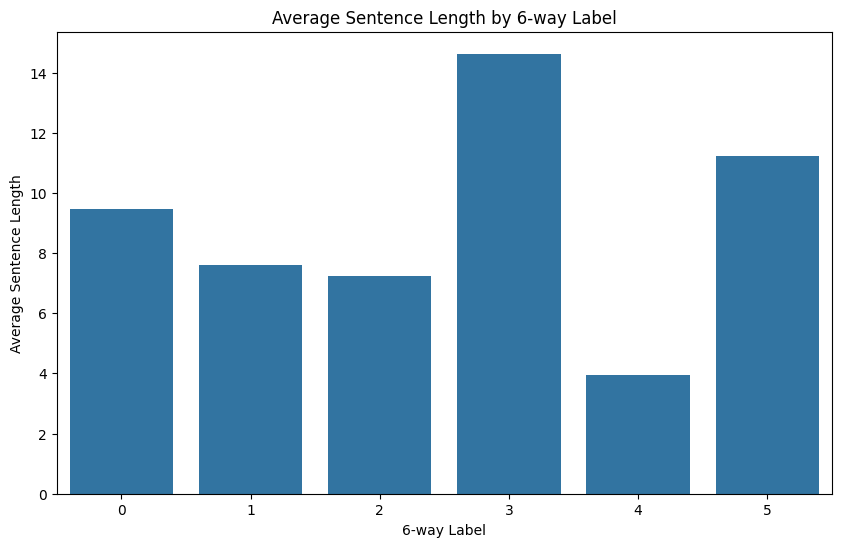

In [ ]:
# Calculate sentence length (if not already calculated)
if 'sentence_length' not in multimodal_train_df.columns:
    multimodal_train_df['sentence_length'] = multimodal_train_df['clean_title'].apply(lambda x: len(str(x).split()))

# Calculate the mean sentence length for each 6-way label
mean_sentence_length = multimodal_train_df.groupby('6_way_label')['sentence_length'].mean().reset_index()

# Create a bar chart
plt.figure(figsize=(10, 6))
sns.barplot(x='6_way_label', y='sentence_length', data=mean_sentence_length)
plt.title('Average Sentence Length by 6-way Label')
plt.xlabel('6-way Label')
plt.ylabel('Average Sentence Length')
plt.show()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


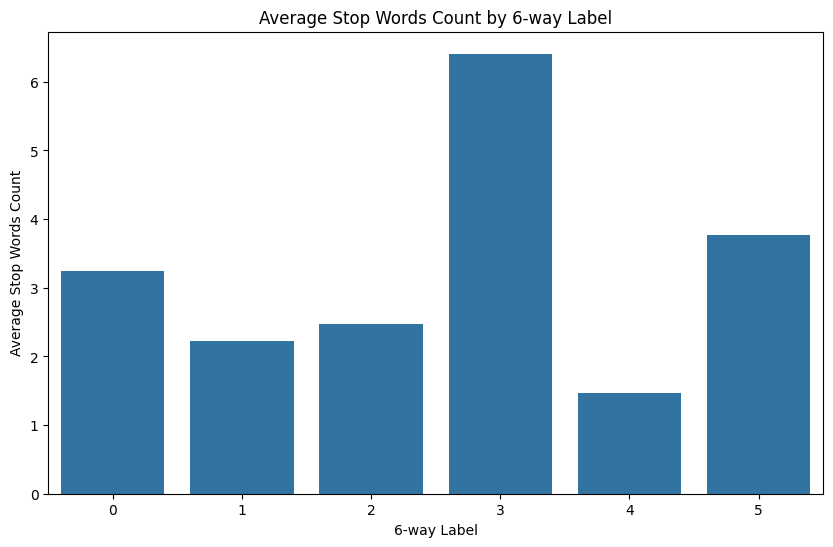

In [ ]:
# Download stopwords if not already downloaded
try:
    stop_words = set(stopwords.words('english'))
except LookupError:
    nltk.download('stopwords')
    stop_words = set(stopwords.words('english'))

# Function to count stop words
def count_stopwords(text):
    if isinstance(text, str):
        words = text.split()
        return sum(1 for word in words if word.lower() in stop_words)
    return 0 # Return 0 for non-string types

# Calculate the number of stop words for each title
multimodal_train_df['stopwords_count'] = multimodal_train_df['clean_title'].apply(count_stopwords)

# Calculate the mean stop words count for each 6-way label
mean_stopwords_count = multimodal_train_df.groupby('6_way_label')['stopwords_count'].mean().reset_index()

# Create a bar chart
plt.figure(figsize=(10, 6))
sns.barplot(x='6_way_label', y='stopwords_count', data=mean_stopwords_count)
plt.title('Average Stop Words Count by 6-way Label')
plt.xlabel('6-way Label')
plt.ylabel('Average Stop Words Count')
plt.show()

Descriptive Statistics for Image Widths:


,0
count,1000.000000
mean,318.613000
std,32.635967
min,108.000000
25%,320.000000
50%,320.000000
75%,320.000000
max,750.000000



Descriptive Statistics for Image Heights:


,0
count,1000.000000
mean,307.030000
std,125.977464
min,54.000000
25%,212.000000
50%,245.000000
75%,426.000000
max,1000.000000


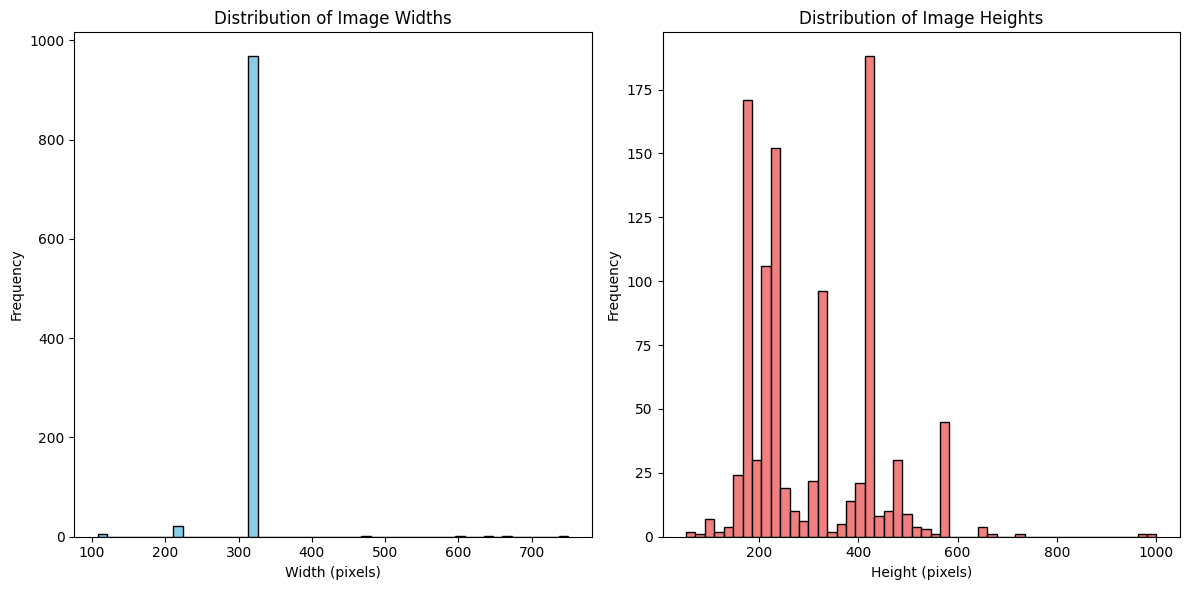

In [ ]:
# Load the dataset
train_df = pd.read_csv('/content/drive/MyDrive/Eva_Pipe/train_image_info_full.csv')
valid_df = pd.read_csv('/content/drive/MyDrive/Eva_Pipe/validate_image_info_full.csv')
test_df = pd.read_csv('/content/drive/MyDrive/Eva_Pipe/test_image_info_full.csv')

# Initialize empty lists to store image widths and heights
image_widths = []
image_heights = []

# Iterate through each image path in the train_df['image_path'] column
for image_path in train_df['image_path']:
    try:
        # Open the image using PIL.Image.open()
        with Image.open(image_path) as img:
            # Get the width and height of the image using the .size attribute
            width, height = img.size
            # Append dimensions to the respective lists
            image_widths.append(width)
            image_heights.append(height)
    except FileNotFoundError:
        print(f"Warning: Image file not found at {image_path}. Skipping.")
        continue
    except Exception as e:
        print(f"Warning: Could not open or process image file at {image_path}: {e}. Skipping.")
        continue

# Convert the lists of widths and heights into pandas Series
image_widths_series = pd.Series(image_widths)
image_heights_series = pd.Series(image_heights)

# Calculate and print descriptive statistics for both the image widths and heights
print("Descriptive Statistics for Image Widths:")
display(image_widths_series.describe())

print("\nDescriptive Statistics for Image Heights:")
display(image_heights_series.describe())

# Create histograms for the image widths and heights to visualize their distributions
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(image_widths_series, bins=50, color='skyblue', edgecolor='black')
plt.title('Distribution of Image Widths')
plt.xlabel('Width (pixels)')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(image_heights_series, bins=50, color='lightcoral', edgecolor='black')
plt.title('Distribution of Image Heights')
plt.xlabel('Height (pixels)')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

Calculating Average Color Values:   0%|          | 0/1000 [00:00<?, ?it/s]


Overall Average Color Distribution:
Average R: 122.6652
Average G: 114.6802
Average B: 107.1445


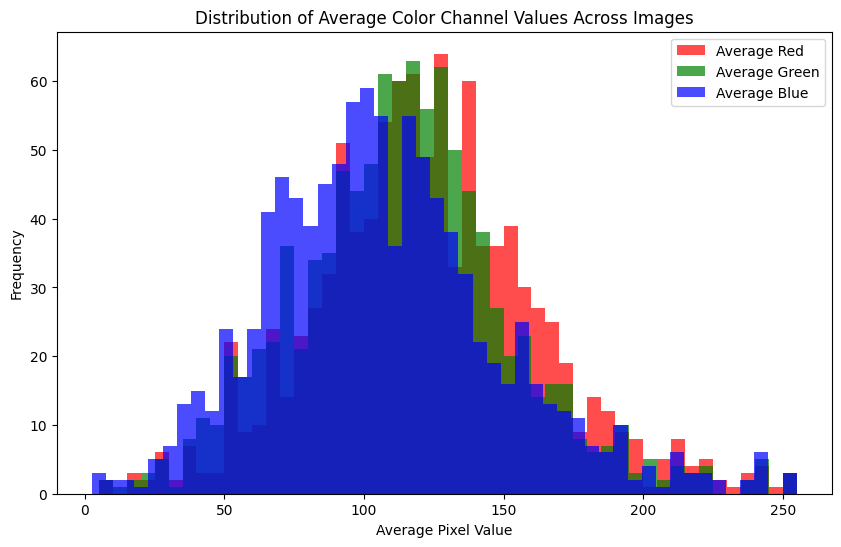

In [ ]:
# Initialize empty lists to store average R, G, and B values for each image
avg_r_values = []
avg_g_values = []
avg_b_values = []

# Iterate through each image path in the train_df['image_path'] column
for image_path in tqdm(train_df['image_path'], desc="Calculating Average Color Values"):
    try:
        # Open the image using PIL.Image.open() and convert it to 'RGB' format
        with Image.open(image_path).convert('RGB') as img:
            # Convert the image to a NumPy array
            img_array = np.array(img)

            # Calculate the mean pixel value for each channel (R, G, B) across the entire image
            # The image array shape is (height, width, channels), so we average over axes 0 and 1
            avg_r = np.mean(img_array[:, :, 0])
            avg_g = np.mean(img_array[:, :, 1])
            avg_b = np.mean(img_array[:, :, 2])

            # Append the calculated mean R, G, and B values to their respective lists
            avg_r_values.append(avg_r)
            avg_g_values.append(avg_g)
            avg_b_values.append(avg_b)

    except FileNotFoundError:
        print(f"Warning: Image file not found at {image_path}. Skipping.")
        continue
    except Exception as e:
        print(f"Warning: Could not open or process image file at {image_path}: {e}. Skipping.")
        continue

# Convert the lists of average color values into pandas Series
avg_r_series = pd.Series(avg_r_values)
avg_g_series = pd.Series(avg_g_values)
avg_b_series = pd.Series(avg_b_values)

# Calculate and print the mean of the average R, G, and B values across all images
print("\nOverall Average Color Distribution:")
print(f"Average R: {avg_r_series.mean():.4f}")
print(f"Average G: {avg_g_series.mean():.4f}")
print(f"Average B: {avg_b_series.mean():.4f}")

# Create a histogram for the average R, G, and B values across all images
plt.figure(figsize=(10, 6))
plt.hist(avg_r_series, bins=50, color='red', alpha=0.7, label='Average Red')
plt.hist(avg_g_series, bins=50, color='green', alpha=0.7, label='Average Green')
plt.hist(avg_b_series, bins=50, color='blue', alpha=0.7, label='Average Blue')
plt.title('Distribution of Average Color Channel Values Across Images')
plt.xlabel('Average Pixel Value')
plt.ylabel('Frequency')
plt.legend()
plt.show()

Calculating Image Sharpness:   0%|          | 0/1000 [00:00<?, ?it/s]


Descriptive Statistics for Image Sharpness:


,0
count,941.000000
mean,1273.179711
std,1453.629791
min,0.000000
25%,413.278054
50%,817.954789
75%,1600.454260
max,15685.232664


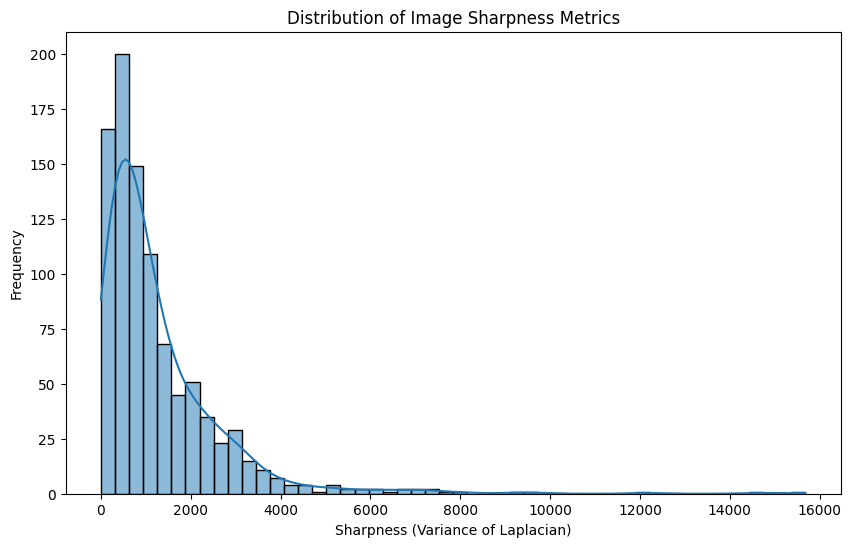

In [ ]:
# Function to calculate image sharpness using the variance of the Laplacian
def calculate_sharpness(image_path):
    """
    Calculates the sharpness of an image using the variance of the Laplacian.
    Returns the variance of the Laplacian or None if the image cannot be processed.
    """
    if not os.path.exists(image_path):
        # print(f"Warning: Image file not found at {image_path}. Skipping.")
        return None # Return None for non-existent files

    try:
        # Open the image using PIL
        img = Image.open(image_path)
        # Convert to grayscale using OpenCV
        img_cv = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2GRAY)
        # Calculate the Laplacian of the grayscale image
        laplacian = cv2.Laplacian(img_cv, cv2.CV_64F)
        # Calculate the variance of the Laplacian
        variance = np.var(laplacian)
        return variance
    except Exception as e:
        # print(f"Warning: Could not process image file at {image_path}: {e}. Skipping.")
        return None # Return None for processing errors


# Initialize a list to store image sharpness metrics
image_sharpness_metrics = []

# Iterate through each image path in the train_df['image_path'] column with a progress bar
for image_path in tqdm(train_df['image_path'], desc="Calculating Image Sharpness"):
    sharpness = calculate_sharpness(image_path)
    if sharpness is not None:
        image_sharpness_metrics.append(sharpness)

# Convert the list of sharpness metrics into a pandas Series
image_sharpness_series = pd.Series(image_sharpness_metrics)

# Calculate and print descriptive statistics for the image sharpness metrics
print("\nDescriptive Statistics for Image Sharpness:")
display(image_sharpness_series.describe())

# Create a histogram to visualize the distribution of image sharpness metrics
plt.figure(figsize=(10, 6))
sns.histplot(image_sharpness_series, bins=50, kde=True)
plt.title('Distribution of Image Sharpness Metrics')
plt.xlabel('Sharpness (Variance of Laplacian)')
plt.ylabel('Frequency')
plt.show()

/tmp/ipython-input-1222832138.py:56: UserWarning: Glyph 12356 (\N{HIRAGANA LETTER I}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-1222832138.py:56: UserWarning: Glyph 12391 (\N{HIRAGANA LETTER DE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-1222832138.py:56: UserWarning: Glyph 12377 (\N{HIRAGANA LETTER SU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-1222832138.py:56: UserWarning: Glyph 12424 (\N{HIRAGANA LETTER YO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 12356 (\N{HIRAGANA LETTER I}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 12391 (\N{HIRAGANA LETTER DE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-package

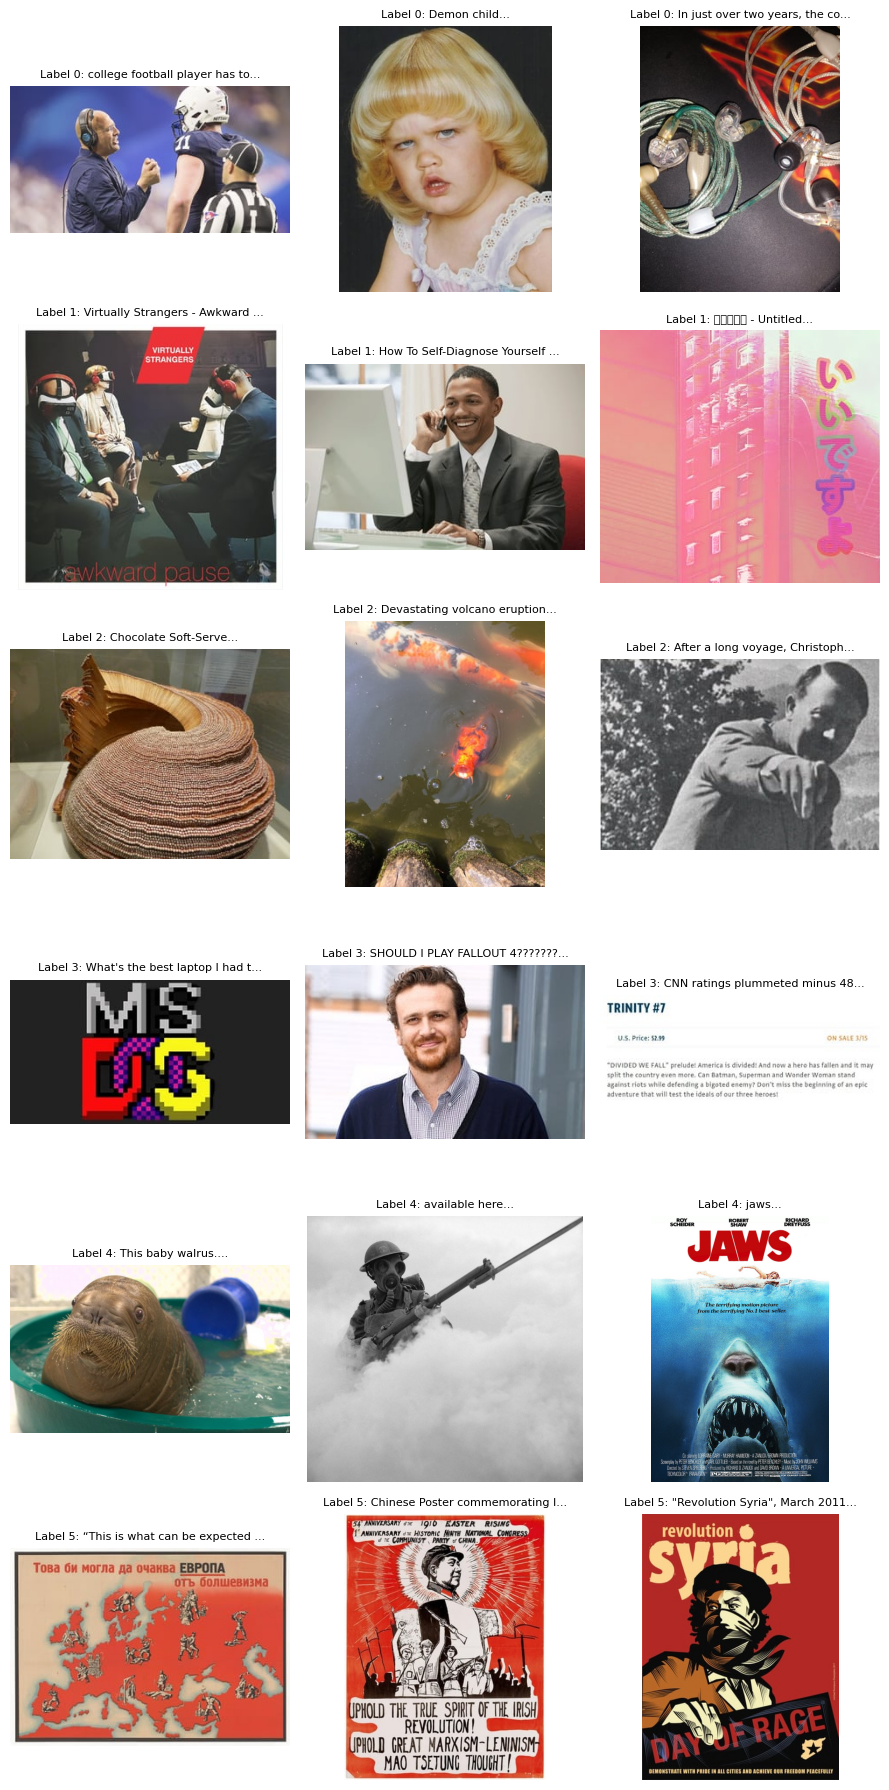

In [ ]:
# Define the number of sample images to display per label
num_samples_per_label = 3

# Get the unique values from the '6_way_label' column of the train_df
unique_labels = sorted(train_df['6_way_label'].unique())

# Create a figure and axes for the plot
# Adjust figure size based on number of labels and samples
fig, axes = plt.subplots(len(unique_labels), num_samples_per_label, figsize=(num_samples_per_label * 3, len(unique_labels) * 3))

# Iterate through each unique 6-way label
for i, label in enumerate(unique_labels):
    # Filter the train_df for the current label
    label_df = train_df[train_df['6_way_label'] == label]

    # Randomly sample image paths for the current label
    # Ensure there are enough samples, otherwise take all available
    sampled_images = label_df.sample(min(num_samples_per_label, len(label_df)))

    # Iterate through the sampled image rows using iterrows
    for j, (index, row) in enumerate(sampled_images.iterrows()):
        # Access the image path and title using column names
        image_path = row['image_path']
        title = row['title'] # Get the original title for display

        # Determine the subplot location
        # Handle cases where there is only one row or one column of subplots
        if len(unique_labels) == 1 and num_samples_per_label == 1:
             ax = axes
        elif len(unique_labels) == 1:
             ax = axes[j]
        elif num_samples_per_label == 1:
             ax = axes[i]
        else:
            ax = axes[i, j]


        try:
            # Open and display the image
            img = Image.open(image_path).convert('RGB')
            ax.imshow(img)
            # Set the title to the corresponding 6-way label and the original title
            ax.set_title(f"Label {label}: {title[:30]}...", fontsize=8) # Truncate long titles
            ax.axis('off') # Turn off the axis
        except FileNotFoundError:
            ax.set_title(f"Label {label}: Image not found", fontsize=8)
            ax.axis('off')
            continue
        except Exception as e:
            ax.set_title(f"Label {label}: Error loading image", fontsize=8)
            ax.axis('off')
            continue


# Adjust layout and display the plot
plt.tight_layout()
plt.show()

Descriptive Statistics of Image Features by 6-way Label:


image_width                                                      \
                  count        mean        std    min    25%    50%     75%   
6_way_label                                                                   
0                 566.0  317.773852  18.669129  108.0  320.0  320.0  320.00   
1                  68.0  320.000000   0.000000  320.0  320.0  320.0  320.00   
2                 287.0  315.651568  20.852894  216.0  320.0  320.0  320.00   
3                  21.0  294.857143  66.116780  108.0  320.0  320.0  320.00   
4                   6.0  629.500000  88.732745  480.0  610.0  640.0  660.25   
5                  52.0  316.000000  20.195127  216.0  320.0  320.0  320.00   

                   image_height              ...       avg_b              \
               max        count        mean  ...         75%         max   
6_way_label                                  ...                           
0            320.0        566.0  295.146643  ...  127.594268  255.000000   
1            320.0         68.0  280.426471  ...  143.866279  252.864121   
2            320.0        287.0  324.442509  ...  128.158775  240.403906   
3            320.0         21.0  262.809524  ...  124.362251  244.496442   
4            750.0          6.0  587.500000  ...  147.721305  190.061580   
5            320.0         52.0  360.557692  ...  145.145447  226.980299   

            sharpness                                                    \
                count         mean          std         min         25%   
6_way_label                                                               
0               532.0  1323.891270  1515.537212    0.000000  397.824460   
1                68.0  1031.716040   988.822898   24.806461  387.400606   
2               266.0  1286.808168  1511.742941    0.000000  463.352842   
3                19.0   975.378367   859.755771   26.216088  365.148341   
4                 6.0  2749.397845  2442.366445  663.075852  902.903334   
5                50.0   925.514256   730.923966   14.233658  397.803837   

                                                     
                     50%          75%           max  
6_way_label                                          
0             866.786224  1765.772355  14606.052801  
1             705.695759  1367.206578   5648.016405  
2             813.292139  1586.241176  15685.232664  
3             789.554332  1584.021277   2781.429503  
4            2246.273519  3405.588675   7093.623844  
5             776.172359  1140.052929   3022.599910  

[6 rows x 48 columns]

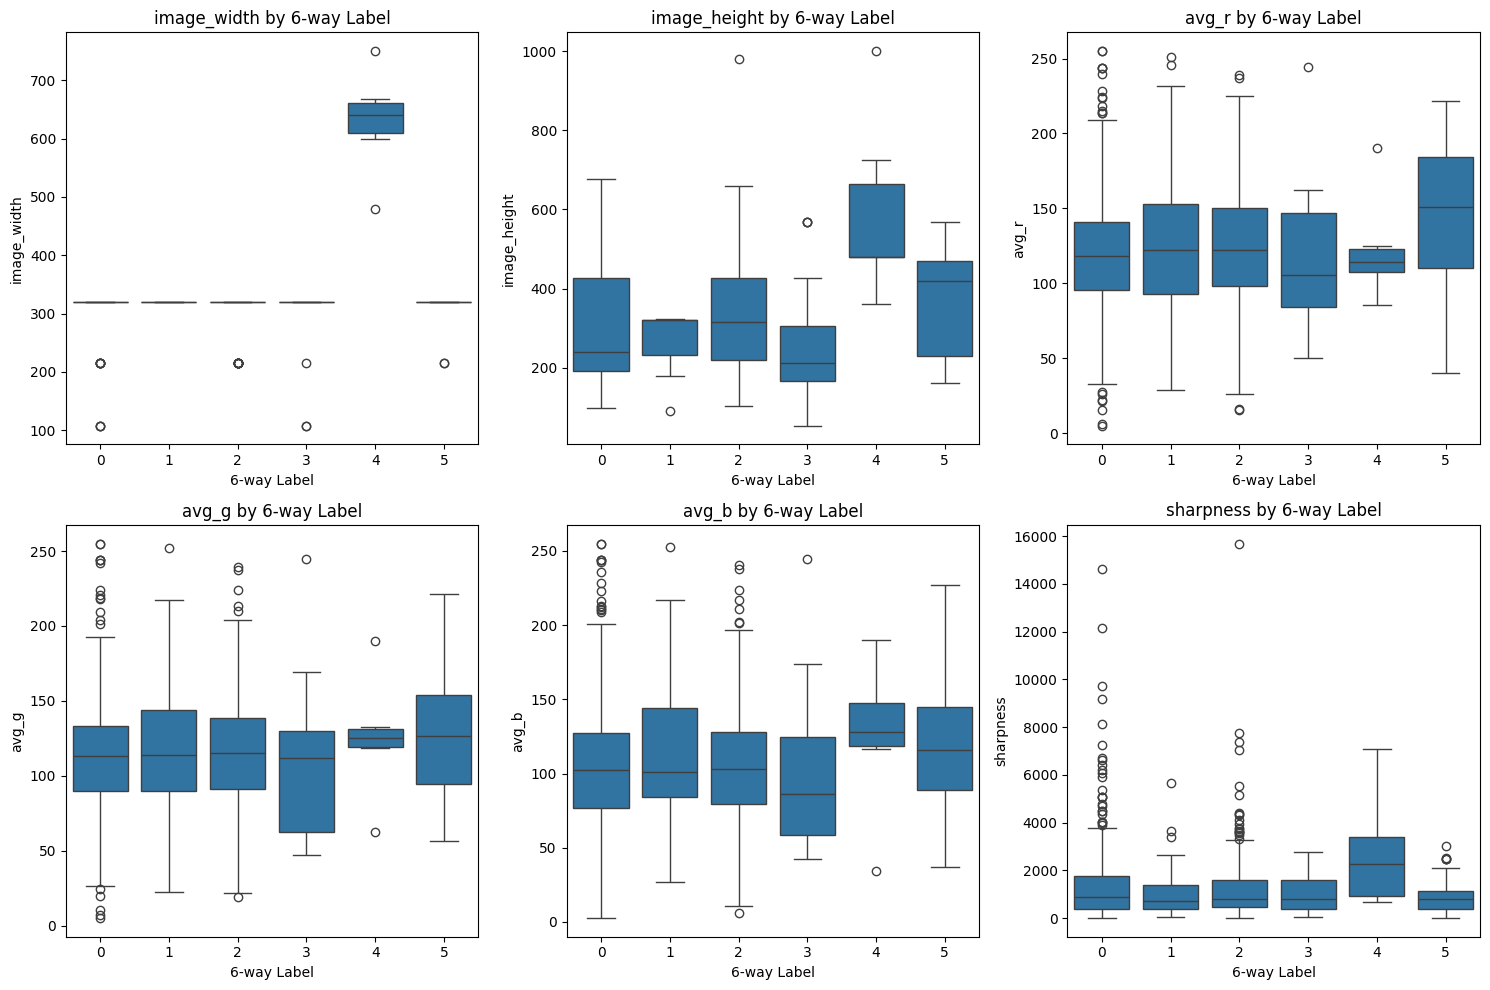

In [ ]:
# Ensure the indices of the series and the train_df align correctly
# This can be done by resetting the index of the series if necessary, or by selecting based on index.
# Since we skipped some images during feature extraction, the length of the series might be less than train_df.
# We need to align them based on the indices of the *successfully processed* images.

# Create a DataFrame from the extracted image features, using the index of the processed images
processed_indices = image_widths_series.index # Assuming all series have the same length and index as they were processed together
image_features_df = pd.DataFrame({
    'image_width': image_widths_series,
    'image_height': image_heights_series,
    'avg_r': avg_r_series,
    'avg_g': avg_g_series,
    'avg_b': avg_b_series,
    'sharpness': image_sharpness_series
})

# Get the corresponding '6_way_label' for the processed images
# Use the index of the image_features_df to select labels from the original train_df
image_features_df['6_way_label'] = train_df.loc[image_features_df.index, '6_way_label'].values

# Calculate and display descriptive statistics for each image feature grouped by '6_way_label'
print("Descriptive Statistics of Image Features by 6-way Label:")
display(image_features_df.groupby('6_way_label').describe())

# Generate visualizations (e.g., box plots or bar plots) for each image feature
# We'll use box plots to show the distribution across labels

image_features = ['image_width', 'image_height', 'avg_r', 'avg_g', 'avg_b', 'sharpness']
plt.figure(figsize=(15, 10))

for i, feature in enumerate(image_features):
    plt.subplot(2, 3, i + 1) # 2 rows, 3 columns
    sns.boxplot(x='6_way_label', y=feature, data=image_features_df)
    plt.title(f'{feature} by 6-way Label')
    plt.xlabel('6-way Label')
    plt.ylabel(feature)

plt.tight_layout()
plt.show()

# **Stopwords Removal and Spell Check**

In [14]:
# Download stopwords if not already downloaded
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def remove_stopwords(text):
    if isinstance(text, str):
        # Remove punctuation and convert to lowercase
        # text = re.sub(r'[^\w\s]', '', text.lower())
        # Remove stopwords
        words = text.split()
        filtered_words = [word for word in words if word not in stop_words]
        return ' '.join(filtered_words)
    return text # Return non-string types as is

# Apply stopword removal to the 'clean_title' column
train_df['clean_title'] = train_df['clean_title'].apply(remove_stopwords)
valid_df['clean_title'] = valid_df['clean_title'].apply(remove_stopwords)
test_df['clean_title'] = test_df['clean_title'].apply(remove_stopwords)

print("Stopwords removed from 'clean_title' column.")

Stopwords removed from 'clean_title' column.


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [15]:
from autocorrect import Speller

# Initialize the spell checker
spell = Speller(lang='en')

# Apply spell check to the 'clean_title' column
train_df['clean_title'] = train_df['clean_title'].apply(lambda x: spell(x) if isinstance(x, str) else x)
valid_df['clean_title'] = valid_df['clean_title'].apply(lambda x: spell(x) if isinstance(x, str) else x)
test_df['clean_title'] = test_df['clean_title'].apply(lambda x: spell(x) if isinstance(x, str) else x)


print("Typos corrected in 'clean_title' column.")

Typos corrected in 'clean_title' column.


# **SVM (Text Classification)**

In [13]:
# Load RoBERTa model and tokenizer
roberta_tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
roberta_model = RobertaModel.from_pretrained('roberta-base')

# Load DistilBERT model and tokenizer
distilbert_tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
distilbert_model = DistilBertModel.from_pretrained('distilbert-base-uncased')

print("Models and tokenizers loaded successfully.")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Models and tokenizers loaded successfully.


In [16]:
def extract_features_batch(texts, tokenizer, model, max_length=128):
    # Handle non-string inputs by converting to empty string
    processed_texts = [str(text) if not isinstance(text, str) else text for text in texts]
    inputs = tokenizer(processed_texts, return_tensors='pt', padding=True, truncation=True, max_length=max_length)
    with torch.no_grad():
        outputs = model(**inputs)
    # Use the mean of the last hidden states as the feature vector
    features = outputs.last_hidden_state.mean(dim=1).squeeze().numpy()
    return features

# Extract features for RoBERTa
# Process in batches to avoid the error
batch_size = 32
roberta_train_features_list = []
for i in range(0, len(train_df), batch_size):
    batch_texts = train_df['clean_title'][i:i+batch_size].tolist()
    batch_features = extract_features_batch(batch_texts, roberta_tokenizer, roberta_model)
    roberta_train_features_list.append(batch_features)

roberta_train_features = np.concatenate(roberta_train_features_list, axis=0)


# Extract features for DistilBERT
distilbert_train_features_list = []
for i in range(0, len(train_df), batch_size):
    batch_texts = train_df['clean_title'][i:i+batch_size].tolist()
    batch_features = extract_features_batch(batch_texts, distilbert_tokenizer, distilbert_model)
    distilbert_train_features_list.append(batch_features)

distilbert_train_features = np.concatenate(distilbert_train_features_list, axis=0)


print("Training Features extracted successfully.")

roberta_test_features_list = []
for i in range(0, len(test_df), batch_size):
    batch_texts = test_df['clean_title'][i:i+batch_size].tolist()
    batch_features = extract_features_batch(batch_texts, roberta_tokenizer, roberta_model)
    roberta_test_features_list.append(batch_features)

roberta_test_features = np.concatenate(roberta_test_features_list, axis=0)


# Extract features for DistilBERT
distilbert_test_features_list = []
for i in range(0, len(test_df), batch_size):
    batch_texts = test_df['clean_title'][i:i+batch_size].tolist()
    batch_features = extract_features_batch(batch_texts, distilbert_tokenizer, distilbert_model)
    distilbert_test_features_list.append(batch_features)

distilbert_test_features = np.concatenate(distilbert_test_features_list, axis=0)


print("test Features extracted successfully.")

Training Features extracted successfully.
test Features extracted successfully.


In [17]:
# Concatenate the features
combined_train_features = np.concatenate((roberta_train_features, distilbert_train_features), axis=1)
combined_test_features = np.concatenate((roberta_test_features, distilbert_test_features), axis=1)

print("Features combined successfully. Shape:", combined_test_features.shape)

Features combined successfully. Shape: (500, 1536)


In [18]:
# Define features (X) and labels (y)
X = combined_train_features
y = train_df['6_way_label']


# Initialize and train the SVM classifier
# Using a linear kernel for simplicity and efficiency, can be changed if needed
svm_model = SVC(kernel='linear', class_weight='balanced')
svm_model.fit(X, y)

print("SVM model trained successfully on the training data.")

SVM model trained successfully on the training data.
